# Testing Fully Connected Architectures

This notebook tests several model architectures for the MNIST dataset. The main goal is both to explore the definition of the architecture, as well as analyzing its impact in the number of parameters.

Although a performance test in terms of accuracy is also performed, note that to draw any meaningful conclusions, at the very least it is required to run each model multiple times and compare the averages. 

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo
# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

import numpy as np
import matplotlib.pyplot as plt
import time

# Auxiliary functions

In [13]:
def show_bad_preds(model, dataset, classes):
    k = 0
    iters = 0

    preds = []
    ground_truth = []
    imgs = torch.Tensor(15, 1, 28,28)

    iterator = iter(dataset)

    max_iters = test_set.__len__() / batch_size
    while k < 15 and iters < max_iters:

        images, targets = next(iterator)
        #print(images[0].shape)
        logits = model(images.to(device))
        
        #print(predictions[0])
        predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
        for i in range(len(predictions)):

            if np.argmax(predictions[i]) != targets[i] and k < 15:

                preds.append(predictions[i])
                ground_truth.append(targets[i])
                imgs[k, :, :, :] = images[i]
                k += 1

        iters += 1

    vcpi_util.plot_predictions(imgs, preds, ground_truth, classes, 5, 3)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


def train(model, data_loader, epochs, loss_fn, optimizer):

    # sets the model in training mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        
    print('Finished Training')

    return(history)




def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(dataset.dataset.classes))


In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

epochs = 50
train_models = True

eval_acc = []
train_acc = []

cuda:0


## Load MNIST dataset

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor()]) 

batch_size = 128

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False)


## Display a few images

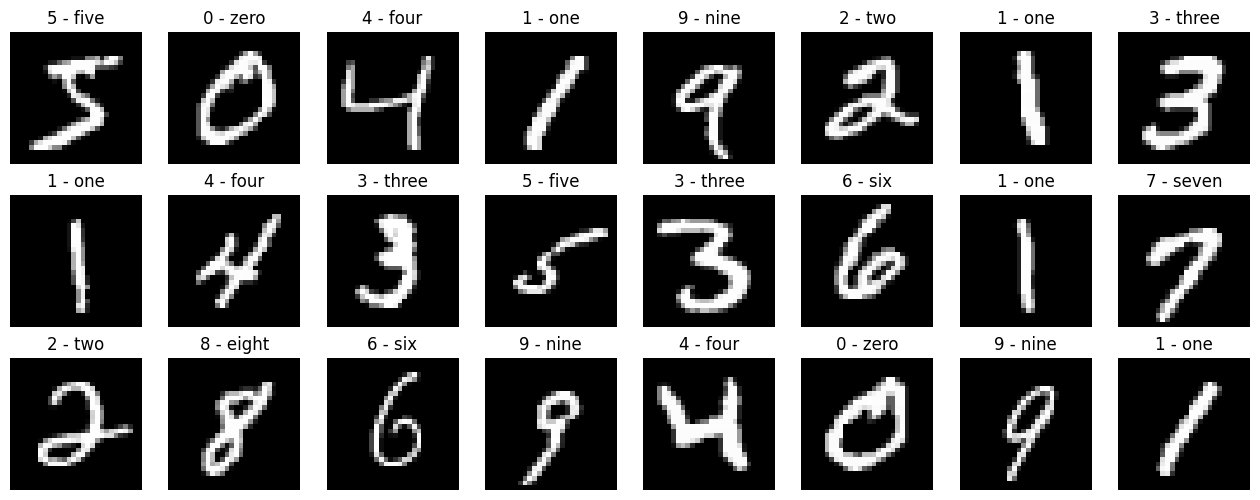

<Figure size 640x480 with 0 Axes>

In [16]:
images, targets = next(iter(train_loader))

# these are the transformed images
vcpi_util.show_transformed_images(3,8, train_set, train_set.classes) 

# Create first model

Single hidden layer with 64 units

In [17]:
class FullyConnected_I(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 64)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(64,num_classes)
        

    def forward(self, x):    

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return(x)




## Display model information

In [18]:
model = FullyConnected_I(len(train_set.classes))
model.to(device)
print(model)

torchinfo.summary(model, input_size=(batch_size, 1, 28, 28))

FullyConnected_I(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_I                         [128, 10]                 --
├─Linear: 1-1                            [128, 64]                 50,240
├─ReLU: 1-2                              [128, 64]                 --
├─Linear: 1-3                            [128, 10]                 650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.51
Input size (MB): 0.40
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.68

## Specify the optimizer, loss and metrics

optimizer: gradient descent optimization algorithm

loss: the loss function upon which derivatives are computed

metrics: metrics to be evaluated during tranining and evaluation

## Train and evaluate the model

In [19]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
if train_models:
    history = train(model, train_loader, epochs, loss_fn, optimizer)

    ###### Saving ######
    torch.save({
        'epoch': epochs,
        'model':model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'history' : history
        },
        f'model_{epochs}.pt')    
else:
    retrieved = torch.load(f'model_{epochs}.pt')
    
    model.load_state_dict(retrieved['model'])
    model.to(device)

    optimizer.load_state_dict(retrieved['optimizer'])
    history = retrieved['history']

train_acc.append(history['accuracy'][-1])

Epoch: 000; Accuracy = 87.5917; Elapsed time: 6.3734
Epoch: 001; Accuracy = 93.2717; Elapsed time: 6.2455
Epoch: 002; Accuracy = 94.7267; Elapsed time: 6.2817
Epoch: 003; Accuracy = 95.6367; Elapsed time: 6.3693
Epoch: 004; Accuracy = 96.2583; Elapsed time: 6.3443
Epoch: 005; Accuracy = 96.7517; Elapsed time: 6.2058
Epoch: 006; Accuracy = 97.1033; Elapsed time: 6.2478
Epoch: 007; Accuracy = 97.4183; Elapsed time: 6.1984
Epoch: 008; Accuracy = 97.6850; Elapsed time: 6.1869
Epoch: 009; Accuracy = 97.9100; Elapsed time: 6.1817
Epoch: 010; Accuracy = 98.1483; Elapsed time: 6.3081
Epoch: 011; Accuracy = 98.3233; Elapsed time: 6.3829
Epoch: 012; Accuracy = 98.4300; Elapsed time: 6.3949
Epoch: 013; Accuracy = 98.5817; Elapsed time: 6.3412
Epoch: 014; Accuracy = 98.7283; Elapsed time: 6.3847
Epoch: 015; Accuracy = 98.8383; Elapsed time: 6.4070
Epoch: 016; Accuracy = 98.9617; Elapsed time: 6.4729
Epoch: 017; Accuracy = 99.0250; Elapsed time: 6.4096
Epoch: 018; Accuracy = 99.1717; Elapsed time: 

## History graphs for accuracy and loss


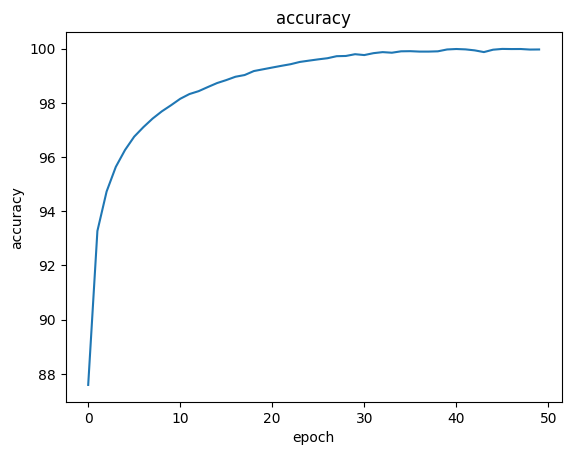

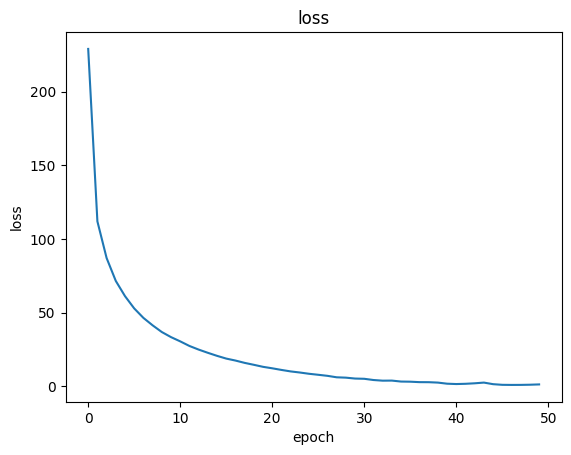

In [21]:
vcpi_util.show_history(history)


## Evaluate the model on the test set

In [22]:
eval_acc.append(evaluate(model, test_loader)*100)

print(eval_acc[-1])

97.46000170707703


# Model 2

wider model, doubling the number of units in the hidden layer

In [23]:
class FullyConnected_II(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128,num_classes)
        

    def forward(self, x):    

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return(x)


## Display model information

In [24]:
model_II = FullyConnected_II(len(train_set.classes))
model_II.to(device)
print(model_II)

torchinfo.summary(model_II, input_size=(batch_size, 1, 28, 28))

FullyConnected_II(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_II                        [128, 10]                 --
├─Linear: 1-1                            [128, 128]                100,480
├─ReLU: 1-2                              [128, 128]                --
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 13.03
Input size (MB): 0.40
Forward/backward pass size (MB): 0.14
Params size (MB): 0.41
Estimated Total Size (MB): 0.95

## Train the model

In [45]:
optimizer_II = torch.optim.Adam(model_II.parameters())

if train_models:
    history_II = train(model_II, train_loader, epochs, loss_fn, optimizer_II)

    ###### Saving ######
    torch.save({
        'epoch': epochs,
        'model':model_II.state_dict(),
        'optimizer': optimizer_II.state_dict(),
        'history' : history_II
        },
        f'model_II_{epochs}.pt')    
else:
    retrieved = torch.load(f'model_II_{epochs}.pt')
    
    model_II.load_state_dict(retrieved['model'])
    model_II.to(device)

    optimizer_II.load_state_dict(retrieved['optimizer'])
    history_II = retrieved['history']



train_acc.append(history_II['accuracy'][-1])

Epoch: 000; Accuracy = 99.9167; Elapsed time: 6.3570
Epoch: 001; Accuracy = 99.9683; Elapsed time: 6.4604
Epoch: 002; Accuracy = 99.9567; Elapsed time: 6.2764
Epoch: 003; Accuracy = 99.9750; Elapsed time: 6.3001
Epoch: 004; Accuracy = 100.0000; Elapsed time: 6.4035
Epoch: 005; Accuracy = 100.0000; Elapsed time: 6.3833
Epoch: 006; Accuracy = 100.0000; Elapsed time: 6.3231
Epoch: 007; Accuracy = 100.0000; Elapsed time: 6.2234
Epoch: 008; Accuracy = 100.0000; Elapsed time: 6.2063
Epoch: 009; Accuracy = 100.0000; Elapsed time: 6.2803
Epoch: 010; Accuracy = 100.0000; Elapsed time: 6.1810
Epoch: 011; Accuracy = 100.0000; Elapsed time: 6.2046
Epoch: 012; Accuracy = 100.0000; Elapsed time: 6.2395
Epoch: 013; Accuracy = 100.0000; Elapsed time: 6.2006
Epoch: 014; Accuracy = 100.0000; Elapsed time: 6.2418
Epoch: 015; Accuracy = 99.6317; Elapsed time: 6.1500
Epoch: 016; Accuracy = 99.9500; Elapsed time: 6.2121
Epoch: 017; Accuracy = 99.9867; Elapsed time: 6.3085
Epoch: 018; Accuracy = 100.0000; El

## History graphs for accuracy and loss

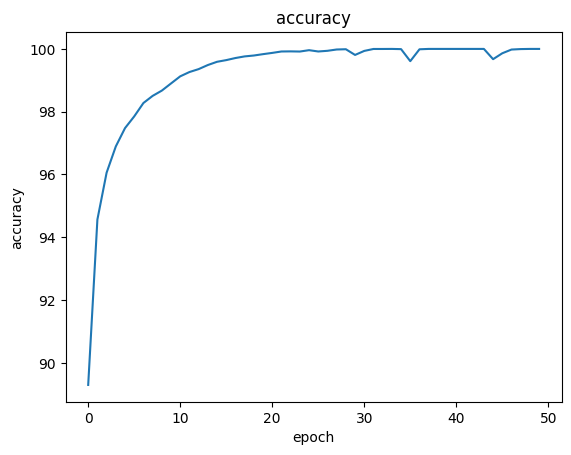

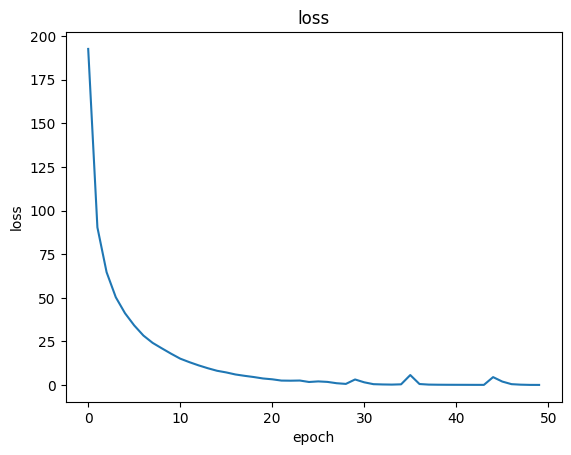

In [26]:
vcpi_util.show_history(history_II)

## Evaluate the model on the test set

In [27]:
eval_acc.append(evaluate(model_II, test_loader)*100)
print(eval_acc[-1])

97.97000288963318


# Model 3

Adding a second hidden layer

In [28]:
class FullyConnected_III(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 128)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128,128)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(128,num_classes)
        

    def forward(self, x):    

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return(x)



In [29]:
model_III = FullyConnected_III(len(train_set.classes))
model_III.to(device)
print(model_III)

torchinfo.summary(model_III, input_size=(batch_size, 1, 28, 28))

FullyConnected_III(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_III                       [128, 10]                 --
├─Linear: 1-1                            [128, 128]                100,480
├─ReLU: 1-2                              [128, 128]                --
├─Linear: 1-3                            [128, 128]                16,512
├─ReLU: 1-4                              [128, 128]                --
├─Linear: 1-5                            [128, 10]                 1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 15.14
Input size (MB): 0.40
Forward/backward pass size (MB): 0.27
Params size (MB): 0.47
Estimated Total Size (MB): 1.15

In [30]:
optimizer_III = torch.optim.Adam(model_III.parameters())

if train_models:
    history_III = train(model_III, train_loader, epochs, loss_fn, optimizer_III)

    ###### Saving ######
    torch.save({
        'epoch': epochs,
        'model':model_III.state_dict(),
        'optimizer': optimizer_III.state_dict(),
        'history' : history_III
        },
        f'model_II_{epochs}.pt')    
else:
    retrieved = torch.load(f'model_III_{epochs}.pt')
    
    model_III.load_state_dict(retrieved['model'])
    model_III.to(device)

    optimizer_III.load_state_dict(retrieved['optimizer'])
    history_III = retrieved['history']


train_acc.append(history_III['accuracy'][-1])

Epoch: 000; Accuracy = 89.8233; Elapsed time: 6.4406
Epoch: 001; Accuracy = 95.4767; Elapsed time: 6.4657
Epoch: 002; Accuracy = 96.8417; Elapsed time: 6.4415
Epoch: 003; Accuracy = 97.4867; Elapsed time: 6.5456
Epoch: 004; Accuracy = 98.0033; Elapsed time: 6.4648
Epoch: 005; Accuracy = 98.3783; Elapsed time: 6.6152
Epoch: 006; Accuracy = 98.6217; Elapsed time: 6.5059
Epoch: 007; Accuracy = 98.8933; Elapsed time: 6.4300
Epoch: 008; Accuracy = 99.1383; Elapsed time: 6.5838
Epoch: 009; Accuracy = 99.2633; Elapsed time: 6.6567
Epoch: 010; Accuracy = 99.3383; Elapsed time: 6.5029
Epoch: 011; Accuracy = 99.4950; Elapsed time: 6.4415
Epoch: 012; Accuracy = 99.5783; Elapsed time: 6.3972
Epoch: 013; Accuracy = 99.6567; Elapsed time: 6.5366
Epoch: 014; Accuracy = 99.4883; Elapsed time: 6.5188
Epoch: 015; Accuracy = 99.6233; Elapsed time: 6.5263
Epoch: 016; Accuracy = 99.5983; Elapsed time: 6.4057
Epoch: 017; Accuracy = 99.6933; Elapsed time: 6.4863
Epoch: 018; Accuracy = 99.7983; Elapsed time: 

In [31]:
###### Saving ######
torch.save({
    'epoch': epochs,
    'model':model_III.state_dict(),
    'optimizer': optimizer_III.state_dict(),
    'history' : history_III
    },
    f'model_III_{epochs}.pt')

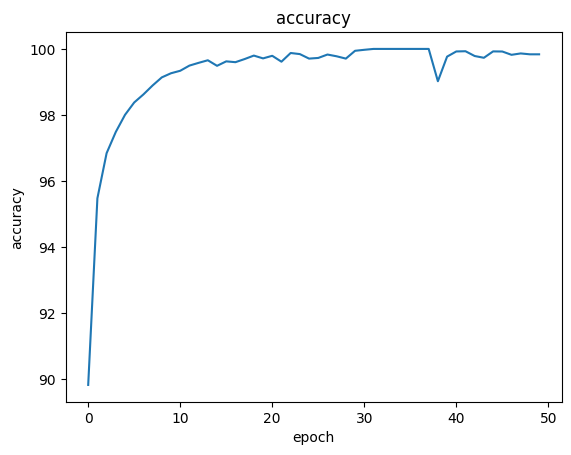

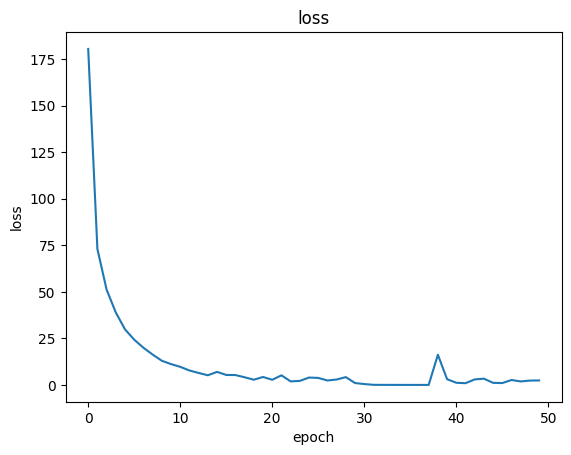

In [32]:
vcpi_util.show_history(history_III)

In [33]:
eval_acc.append(evaluate(model_III, test_loader)*100)
print(eval_acc[-1])

97.83999919891357


# Model 4

Adding a third hidden layer

In [34]:
class FullyConnected_IV(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 256)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256,128)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(128,64)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(64,num_classes)
        

    def forward(self, x):    

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)

        return(x)



In [35]:
model_IV = FullyConnected_IV(len(train_set.classes))
model_IV.to(device)
print(model_IV)

torchinfo.summary(model_IV, input_size=(batch_size, 1, 28, 28))


FullyConnected_IV(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_IV                        [128, 10]                 --
├─Linear: 1-1                            [128, 256]                200,960
├─ReLU: 1-2                              [128, 256]                --
├─Linear: 1-3                            [128, 128]                32,896
├─ReLU: 1-4                              [128, 128]                --
├─Linear: 1-5                            [128, 64]                 8,256
├─ReLU: 1-6                              [128, 64]                 --
├─Linear: 1-7                            [128, 10]                 650
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 31.07
Input size (MB): 0.40
Forward/backward pass size (MB): 0.47
Params size (MB): 0.97
Estimated Total Size (MB): 1.84

In [44]:
optimizer_IV = torch.optim.Adam(model_IV.parameters())

if train_models:
    history_IV = train(model_IV, train_loader, epochs, loss_fn, optimizer_IV)

    ###### Saving ######
    torch.save({
        'epoch': epochs,
        'model':model_IV.state_dict(),
        'optimizer': optimizer_IV.state_dict(),
        'history' : history_IV
        },
        f'model_IV_{epochs}.pt')    
else:
    retrieved = torch.load(f'model_IV_{epochs}.pt')
    
    model_IV.load_state_dict(retrieved['model'])
    model_IV.to(device)

    optimizer_IV.load_state_dict(retrieved['optimizer'])
    history_IV = retrieved['history']

train_acc.append(history_IV['accuracy'][-1])

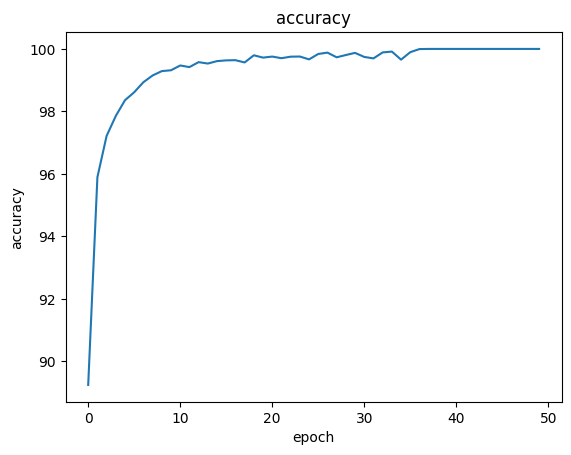

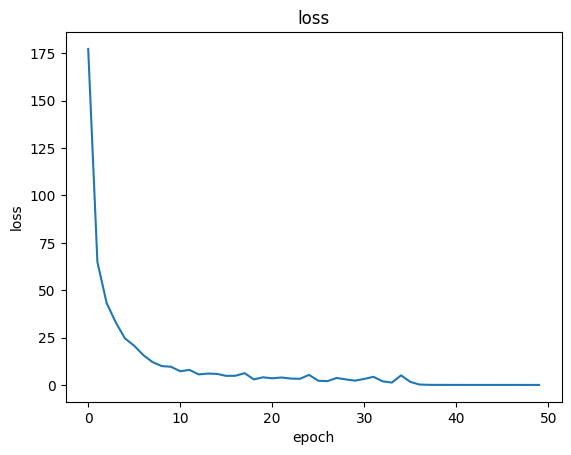

In [37]:
vcpi_util.show_history(history_IV)

In [38]:
eval_acc.append(evaluate(model_IV, test_loader)*100)
print(eval_acc[-1])

98.55999946594238


# Show Results

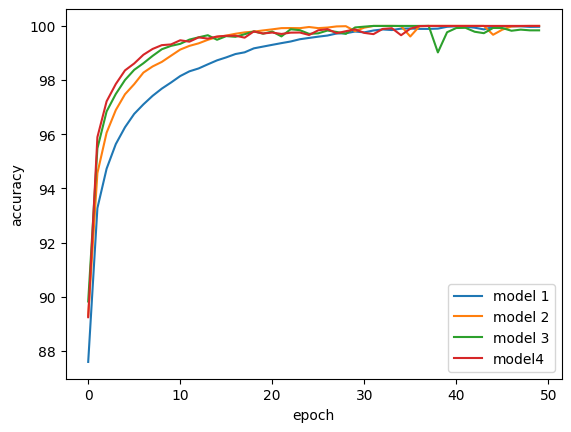

In [39]:
vcpi_util.show_histories([history, history_II, history_III, history_IV], ['model 1', 'model 2', 'model 3', 'model4'])       

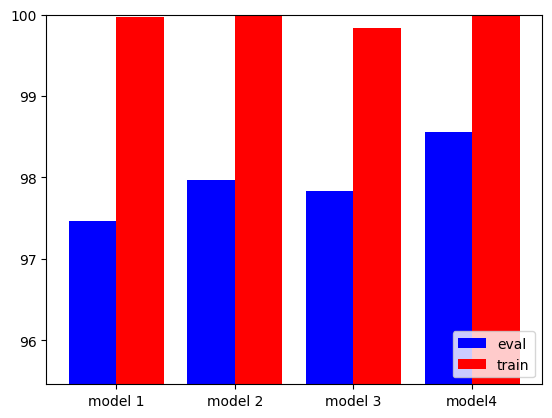

In [40]:
vcpi_util.show_accuracies(train_acc, eval_acc, ['model 1', 'model 2', 'model 3', 'model4'])  


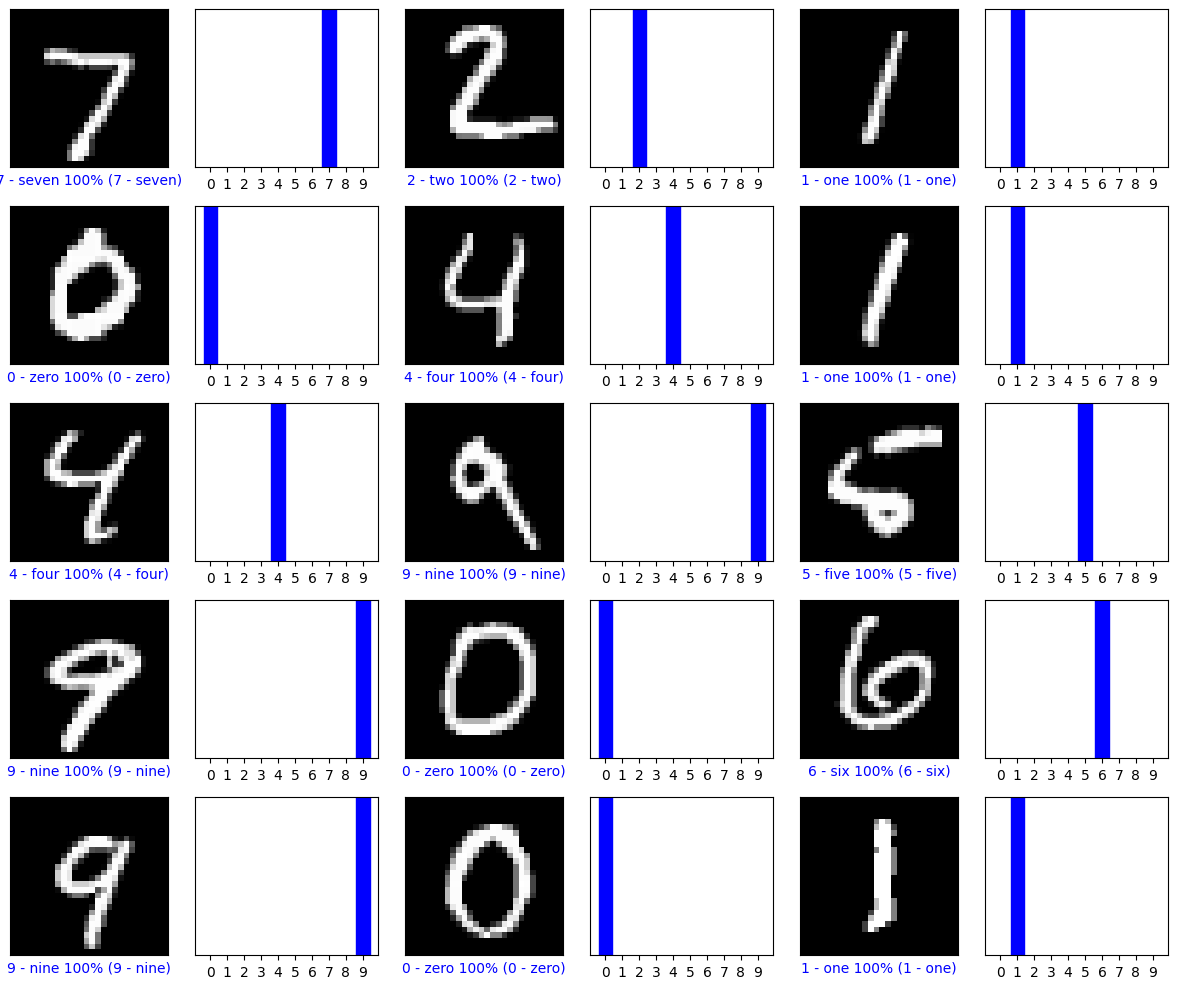

In [41]:
images, targets = next(iter(test_loader))
logits = model_IV(images.to(device))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()

vcpi_util.plot_predictions(images, predictions, targets, train_set.classes, 5, 3)

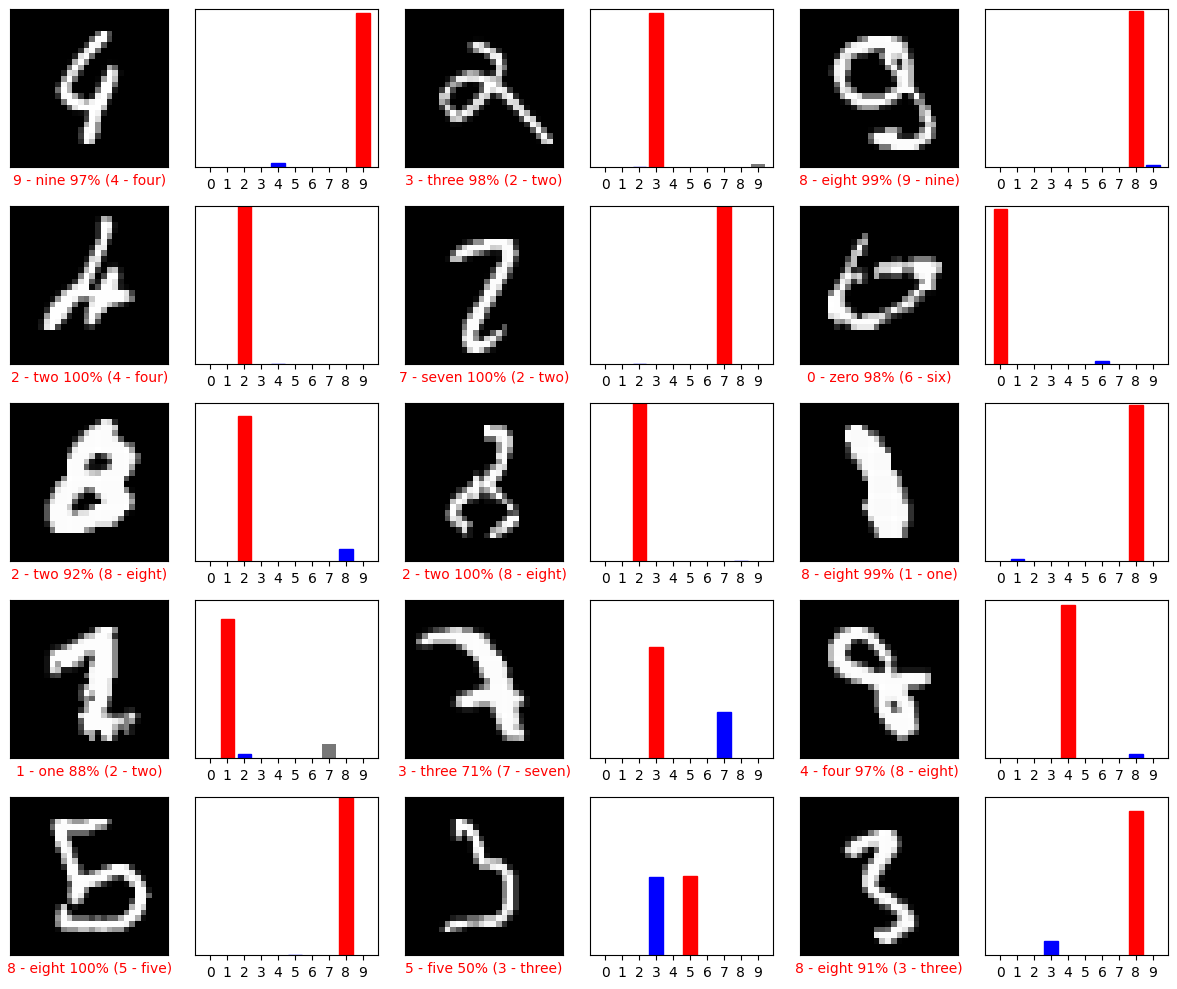

In [42]:
show_bad_preds(model_IV, test_loader, test_set.classes)    

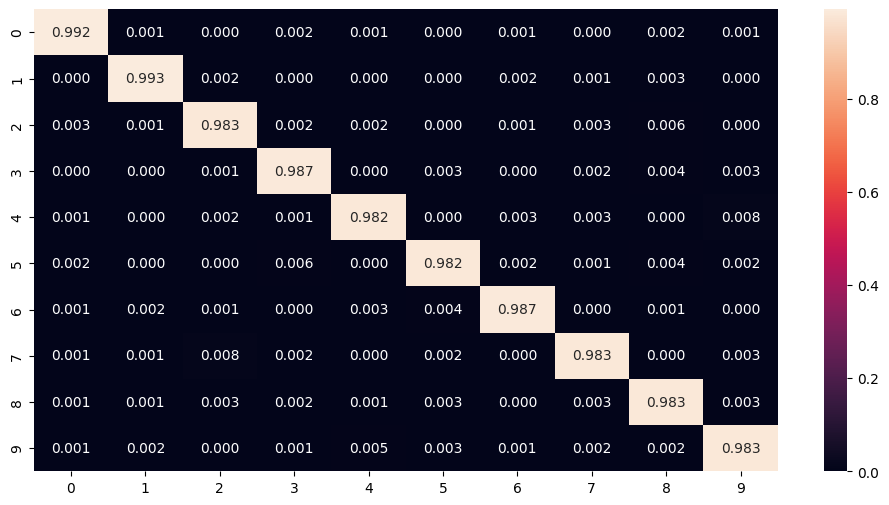

In [43]:
build_confusion_matrix(model_IV, test_loader)